In [198]:
import sys
from pathlib import Path
import pandas as pd
import numpy as np
from datetime import date, timedelta


repo_root = Path().resolve().parent
sys.path.append(str(repo_root))

In [ ]:
from vnstock import Listing, Quote
list = Listing(source='vci')
VN30 = list.symbols_by_group('VN30').tolist()
#tickers = [t for t in VN30]
day_range = 365 
tickers = ['HCM', 'ACB', 'SSI', 'HPG']
end = (date.today()).isoformat()
start = (date.today() - timedelta(days=day_range)).isoformat()



In [200]:
import src.fetch_info as fetch

raw = fetch.fetch_stock(tickers=tickers,interval='1d',hist=day_range, combine=False)


Fetching HCM...
Done!

Fetching ACB...
Done!

Fetching SSI...
Done!

Fetching HPG...
Done!



In [201]:
for i in raw:
    stock = raw[i]
    stock['ret'] = np.log(stock['close'] / stock['close'].shift(1)) 
    stock.dropna(subset=['ret'], inplace=True)
    stock['ticker'] = i
    print(stock.isna().sum().sum())


0
0
0
0


In [202]:
df = []
for i in raw:
    df.append(raw[i])
df = pd.concat(df)
df['mvol'] = df['close'] * df['volume']
df = df[['time','ticker','close', 'mvol', 'ret']]

In [203]:
from IPython.display import clear_output   
import src.mpt as mpt

sims = 4000

result = mpt.mpt_sim(df, sims)

result

Index(['ACB', 'HCM', 'HPG', 'SSI'], dtype='object', name='ticker')


,Return,Volatility,Weight
3631,0.000981,0.022321,"{'ACB': 0.006049775622133104, 'HCM': 0.0051177..."
2554,0.000968,0.022365,"{'ACB': 0.009692583795053838, 'HCM': 0.0237176..."
229,0.000967,0.022094,"{'ACB': 0.003636170889247574, 'HCM': 0.0080911..."
160,0.000957,0.021867,"{'ACB': 0.04212807190539675, 'HCM': 0.01151725..."
3612,0.000942,0.021552,"{'ACB': 0.06452669679160367, 'HCM': 0.01362007..."
...,...,...,...
1696,0.000047,0.020609,"{'ACB': 0.007210687786290538, 'HCM': 0.9006970..."
2767,0.000038,0.019551,"{'ACB': 0.12507406042962338, 'HCM': 0.84719600..."
3018,0.000033,0.019830,"{'ACB': 0.04672357344928559, 'HCM': 0.86075549..."
3480,0.000019,0.019953,"{'ACB': 0.05743276933230984, 'HCM': 0.88268382..."


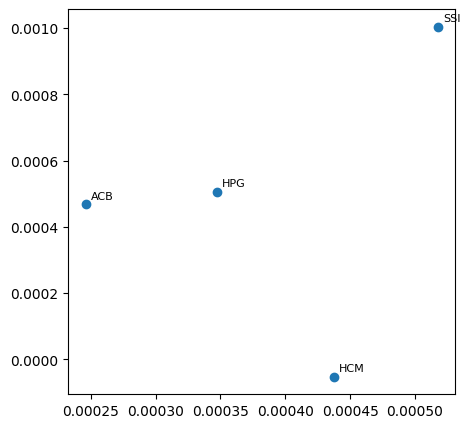

In [204]:
import seaborn as sns
import matplotlib.pyplot as plt
aggregate = df.groupby('ticker')['ret'].agg(['mean', 'std','var'])  

plt.figure(figsize=(5,5))
plt.scatter(aggregate['var'], aggregate['mean'])

for x, y, label in zip(aggregate['var'], aggregate['mean'], aggregate.index):
    plt.annotate(label, (x, y), xytext=(4, 4), textcoords="offset points", fontsize=8)



In [205]:
W = pd.DataFrame(result["Weight"].to_list(), index=result.index).add_prefix("w_")
result2 = pd.concat([result.drop(columns=["Weight"]), W], axis=1)
fin = result2.sort_values(['Return', 'Volatility'], ascending=[False, True])
fin


,Return,Volatility,w_ACB,w_HCM,w_HPG,w_SSI
3631,0.000981,0.022321,0.006050,0.005118,0.029691,0.959141
2554,0.000968,0.022365,0.009693,0.023718,0.010886,0.955704
229,0.000967,0.022094,0.003636,0.008091,0.052912,0.935361
160,0.000957,0.021867,0.042128,0.011517,0.024112,0.922243
3612,0.000942,0.021552,0.064527,0.013620,0.025336,0.896517
...,...,...,...,...,...,...
1696,0.000047,0.020609,0.007211,0.900697,0.004384,0.087708
2767,0.000038,0.019551,0.125074,0.847196,0.008881,0.018849
3018,0.000033,0.019830,0.046724,0.860755,0.073845,0.018676
3480,0.000019,0.019953,0.057433,0.882684,0.043285,0.016598


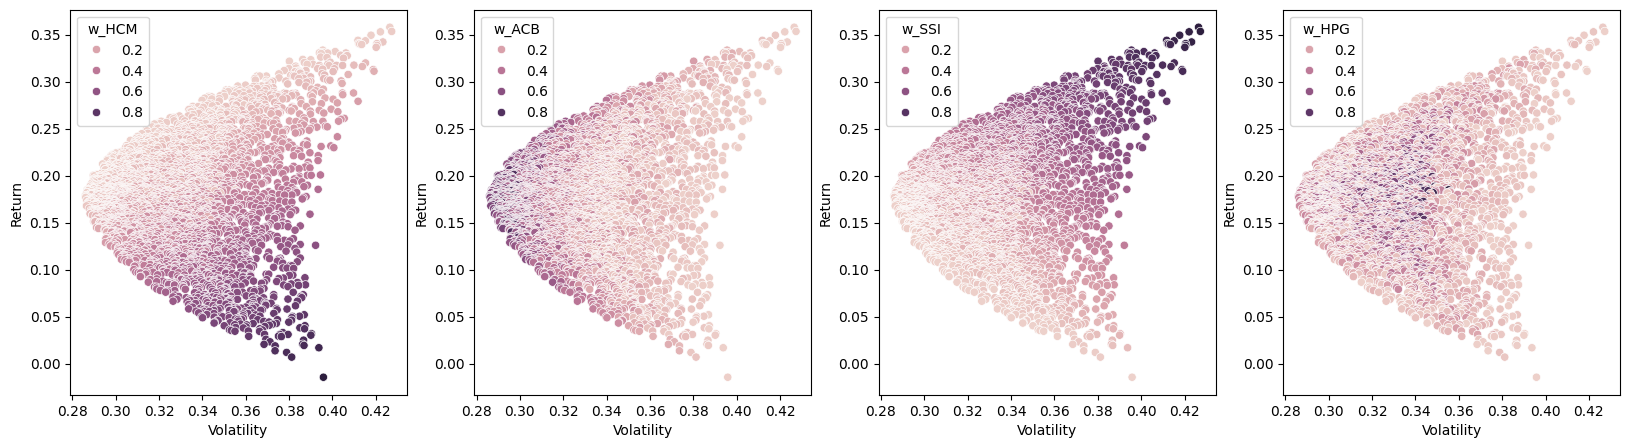

In [209]:
import seaborn as sns
import matplotlib.pyplot as plt
import math 

fig, axs = plt.subplots(1, len(tickers), figsize=(20, 5), sharex=False, sharey=False)


for i in range(len(tickers)):
    sns.scatterplot(x=fin['Volatility'] * math.sqrt(day_range), y=fin['Return'] * day_range,hue=fin[f'w_{tickers[i]}'], ax=axs[i])


In [207]:
fin.head(100).agg(['mean', 'std'])

,Return,Volatility,w_ACB,w_HCM,w_HPG,w_SSI
mean,0.000866,0.020560,0.085390,0.047927,0.084271,0.782413
std,0.000041,0.000848,0.065247,0.035353,0.065711,0.073164


<Axes: xlabel='time', ylabel='close'>

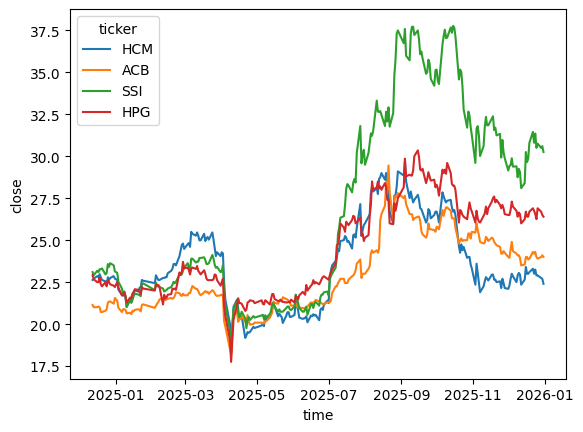

In [214]:
sns.lineplot(x=df['time'], y=df['close'], hue=df['ticker'])